In [1]:
#test which virtualenv running in
import sys
sys.prefix

'/usr'

In [2]:
import tensorflow as tf
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
from google.cloud import storage

from config import TRANSFORMED_TRAIN_ANNOTATIONS_PATH,TRANSFORMED_VALIDATION_ANNOTATIONS_PATH,IMAGE_SIZE
from models.six_stage_linear_model import ModelMaker
import dataset_functions
import visualizations as v

In [3]:
tf.version.VERSION

'2.1.0-dev20191124'

In [4]:
#Training config, can be moved later to main config
CACHE=False
CACHE_RAMFS=False #uses a ramfs file to force using main memory
BATCH_SIZE=32  #must be small if caching
SHUFFLE=True
PREFETCH=10  #size of prefetch size, 0 to disable

#TODO
Dataset side
* add apropirate settings for TFRecordDataset -V
* cache (before transformations) just to avoid disk access (should be ~9gigs) -V
* move cache to ramfs -V
* add augmentation ,after cache, probably before transformations 
* add prefetch, shuffle -V 
* create validation dataset -V

Compilation side
* add tensorboard callback
* add hyper parameters (learning rate, learning rate decay)
* add metrics (accuracy)
* add validation

All
* add comments

TPUs
* try with TPUs

In [5]:
tpu_ip='10.0.3.2'
# !!!MAKE SURE THE TPU ADDRESS IS CORRECT!!
# 1.ip must be correct
# 2.tpu must be turned on!
# 3.version must be 'nightly-2.x'
# 4.tpu must be reachable (check with gce netowrking/connectivity test)
# if not this will hang
tpu_address = 'grpc://'+tpu_ip+':8470'
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=tpu_address)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

INFO:tensorflow:Initializing the TPU system: 10.0.3.2:8470


INFO:tensorflow:Initializing the TPU system: 10.0.3.2:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


---
Caching using ramfs (irrelevant for tpu)

In [11]:
if CACHE_RAMFS:
    !mkdir /tmp/ramdisk
    !sudo umount /tmp/ramdisk
    !sudo mount -t ramfs -o size=512m ramfs /tmp/ramdisk
    !sudo chown $LOGNAME:$LOGNAME /tmp/ramdisk

In [6]:
if CACHE_RAMFS:
    cache_loc="/tmp/ramdisk/cache_t"
    cache_v_loc="/tmp/ramdisk/cache_v"
else:
    cache_loc=None
    cache_v_loc=None

In [7]:
cache_loc

---
# Make dataset

In [15]:
label_transformer=dataset_functions.LabelTransformer()
@tf.function
def make_label_tensors(elem):
    """Transforms a dict data element:
    1.Read jpg to tensor 
    1.1 Resize img to correct size for network
    2.Convert keypoints to correct form label tensor
    3.Convert joints to correct form label tensor
    outputs a tuple data element"""
    
    idd=elem['id']
    kpt_tr=label_transformer.keypoints_spots_vmapfn(elem['kpts'])
    paf_tr=label_transformer.joints_PAFs(elem['joints'])
    
    image_raw=elem["image_raw"]
    image=tf.image.decode_jpeg(image_raw,channels=3)
    image=tf.image.convert_image_dtype(image,dtype=tf.float32)
    image=tf.image.resize(image,IMAGE_SIZE)
    return image,(paf_tr,kpt_tr),idd

In [16]:
@tf.function
def place_training_labels(image,labels,idd):
    """Disterbutes labels into the correct configuration for the model, ie 4 PAF stage, 2 kpt stages
    must match the model"""
    paf_tr=labels[0]
    kpt_tr=labels[1]
    return image,(paf_tr,paf_tr,paf_tr,paf_tr,kpt_tr,kpt_tr) #this should match the model outputs, and is different for each model

Read and Parse the TFrecords

In [17]:
DATASET_SIZE=56000 #exact size not critical
DATASET_VAL_SIZE=2500 

----
figure out GCS storage


In [18]:
train_prefix=TRANSFORMED_TRAIN_ANNOTATIONS_PATH.split(os.sep)[-1]
val_prefix=TRANSFORMED_VALIDATION_ANNOTATIONS_PATH.split(os.sep)[-1]

In [19]:
bucket_name="datasets_bucket_a"
gs_prefix="gs://"

In [20]:
storage_client = storage.Client() #must have apropriate authenitication to work 

train_blobs = storage_client.list_blobs(bucket_name,prefix=train_prefix)
val_blobs = storage_client.list_blobs(bucket_name,prefix=val_prefix)

In [21]:
tfrecord_files_train=[gs_prefix+bucket_name+'/'+blob.name for blob in train_blobs]
tfrecord_files_val=[gs_prefix+bucket_name+'/'+blob.name for blob in val_blobs]

In [22]:
#tfrecord_files_train

In [23]:
ds = tf.data.TFRecordDataset(tfrecord_files_train)

In [24]:
TF_parser=dataset_functions.TFrecordParser() #used for 

#order of transformations is critical!

#TFrecord files to raw format
ds = tf.data.TFRecordDataset(tfrecord_files_train) #numf reads can be put here, but I don't think I/O is the bottleneck

#raw format to imgs,tensors(coords kpts)
ds=ds.map(TF_parser.read_tfrecord)

#cache  ,caching is here before decompressing jpgs and label tensors (should be ~9GB) , (full dataset should be ~90, cache later if RAM aviable)
if CACHE: ds=ds.cache(cache_loc)
if SHUFFLE: ds=ds.shuffle(100)    
    
#Augmentation should be here, to operate on smaller tensors
    
#imgs,tensors to label_tensors (46,46,17/38)
ds=ds.map(make_label_tensors)
#imgs,label_tensors arrange for model outputs
ds=ds.map(place_training_labels) 

#batch
ds=ds.batch(BATCH_SIZE)
#repeat
ds=ds.repeat()
#prefetch
if PREFETCH: ds=ds.prefetch(PREFETCH)

Make validation dataset

In [25]:
TF_parser=dataset_functions.TFrecordParser() #used for 

#order of transformations is critical!

#TFrecord files to raw format
ds_v = tf.data.TFRecordDataset(tfrecord_files_val) #numf reads can be put here, but I don't think I/O is the bottleneck
#raw format to imgs,tensors(coords kpts)
ds_v=ds_v.map(TF_parser.read_tfrecord)   

#cache  
if CACHE: ds_v=ds_v.cache(cache_v_loc)
    
#imgs,tensors to label_tensors (46,46,17/38)
ds_v=ds_v.map(make_label_tensors)
#imgs,label_tensors arrange for model outputs
ds_v=ds_v.map(place_training_labels) 
#batch
ds_v=ds_v.batch(BATCH_SIZE)


Examine datasets

In [26]:
st=next(iter(ds))
#st
#st_v=next(iter(ds_v))
#v.show_pafs_kpts_img()

In [27]:
len(st[0])

32

In [28]:
ds

<PrefetchDataset shapes: ((None, 368, 368, 3), ((None, 46, 46, 38), (None, 46, 46, 38), (None, 46, 46, 38), (None, 46, 46, 38), (None, 46, 46, 17), (None, 46, 46, 17))), types: (tf.float32, (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32))>

In [17]:
ds_v

<BatchDataset shapes: ((None, 368, 368, 3), ((None, 46, 46, 38), (None, 46, 46, 38), (None, 46, 46, 38), (None, 46, 46, 38), (None, 46, 46, 17), (None, 46, 46, 17))), types: (tf.float32, (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32))>

In [37]:
st[0][0]

<tf.Tensor: shape=(368, 368, 3), dtype=float32, numpy=
array([[[0.05532822, 0.06709293, 0.03179881],
        [0.07052337, 0.08228808, 0.04699396],
        [0.06334186, 0.07510657, 0.03981245],
        ...,
        [0.37307703, 0.48586452, 0.53113323],
        [0.36412972, 0.50053203, 0.51834977],
        [0.3777751 , 0.5146538 , 0.52249694]],

       [[0.05824716, 0.07001186, 0.03471775],
        [0.06996739, 0.08173209, 0.04643798],
        [0.05822678, 0.06999148, 0.03469736],
        ...,
        [0.37470156, 0.4907972 , 0.53454804],
        [0.34674913, 0.48334607, 0.5011638 ],
        [0.30961162, 0.44034666, 0.4481898 ]],

       [[0.06957078, 0.08133548, 0.04604137],
        [0.07570333, 0.08746804, 0.05217392],
        [0.0570036 , 0.0687683 , 0.03347418],
        ...,
        [0.38429973, 0.5093932 , 0.5563966 ],
        [0.46911287, 0.6006226 , 0.62109977],
        [0.458533  , 0.5732926 , 0.58522224]],

       ...,

       [[0.33166194, 0.28664914, 0.21512312],
        [0.27

---
# Model

In [30]:
@tf.function
def mse_2d_loss(y_true, y_pred):
    pixel_losses=tf.keras.losses.mean_squared_error(y_true, y_pred)
    return tf.math.reduce_mean(pixel_losses,axis=-1)

In [31]:
with strategy.scope():
    model_maker=ModelMaker()
    train_model,test_model=model_maker.create_models()
    train_model.compile(optimizer=tf.keras.optimizers.Adam()
                    ,loss=mse_2d_loss
                    #,metrics=["acc"]
                   )

In [32]:
train_model

---
Actually training

In [33]:
steps_per_epoch=int(DATASET_SIZE/BATCH_SIZE)

In [35]:
train_model.fit(ds,epochs=2,steps_per_epoch=steps_per_epoch,validation_data=ds_v)

Train for 1750 steps
Epoch 1/2


1749/1750 [============================>.] - ETA: 0s - loss: 0.0647 - stage1paf_output_loss: 7.9638e-04 - stage2paf_output_loss: 8.4872e-04 - stage3paf_output_loss: 8.1185e-04 - stage4paf_output_loss: 7.9886e-04 - stage5heatmap_output_loss: 0.0292 - stage6heatmap_output_loss: 0.0322WARNING:tensorflow:5 out of the last 13 calls to <function mse_2d_loss at 0x7f7eb7eec2f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


1750/1750 [==============================] - 714s 408ms/step - loss: 0.0647 - stage1paf_output_loss: 7.9644e-04 - stage2paf_output_loss: 8.4875e-04 - stage3paf_output_loss: 8.1190e-04 - stage4paf_output_loss: 7.9892e-04 - stage5heatmap_output_loss: 0.0292 - stage6heatmap_output_loss: 0.0322 - val_loss: 0.0490 - val_stage1paf_output_loss: 7.7580e-04 - val_stage2paf_output_loss: 7.7580e-04 - val_stage3paf_output_loss: 7.7580e-04 - val_stage4paf_output_loss: 7.7580e-04 - val_stage5heatmap_output_loss: 0.0222 - val_stage6heatmap_output_loss: 0.0237
Epoch 2/2
1750/1750 [==============================] - 1024s 585ms/step - loss: 0.0411 - stage1paf_output_loss: 7.9490e-04 - stage2paf_output_loss: 7.9490e-04 - stage3paf_output_loss: 7.9490e-04 - stage4paf_output_loss: 7.9490e-04 - stage5heatmap_output_loss: 0.0197 - stage6heatmap_output_loss: 0.0183 - val_loss: 0.0372 - val_stage1paf_output_loss: 7.7580e-04 - val_stage2paf_output_loss: 7.7580e-04 - val_stage3paf_output_loss: 7.7580e-04 - val_s

In [40]:
save_dir="./saved_models/"
train_model.save(save_dir+"first_model_2epochs.h5")
train_model.save_weights(save_dir+"first_model_2epochs_weights.h5")

testing

In [43]:
inp=st[0][0:1]

In [45]:
results=train_model.predict(inp)

In [48]:
results[4][0].shape

(46, 46, 17)

In [54]:
inp.numpy().shape

(1, 368, 368, 3)

In [78]:
batch_idx=1
true_img=st[0][batch_idx].numpy()
true_paf=st[1][3][batch_idx]
true_kpts=st[1][5][batch_idx]

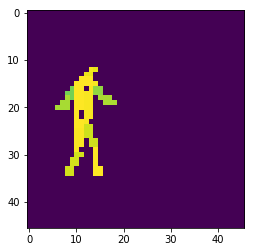

In [84]:
plt.imshow(abs(true_paf.numpy()).max(axis=-1))

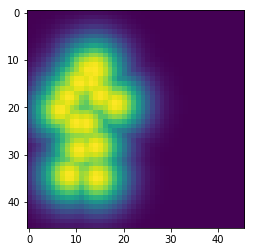

In [85]:
plt.imshow(abs(true_kpts.numpy()).max(axis=-1))

In [93]:
predict_paf=results[1][0]
predict_kpts=results[5][0]

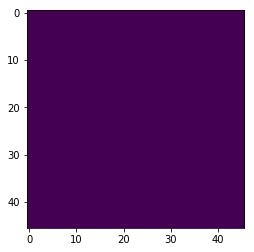

In [94]:
plt.imshow(abs(predict_paf).max(axis=-1))

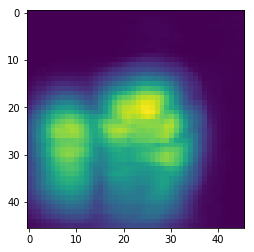

In [92]:
plt.imshow(abs(predict_kpts).max(axis=-1))

ValueError: could not broadcast input array from shape (46,46) into shape (46,17)

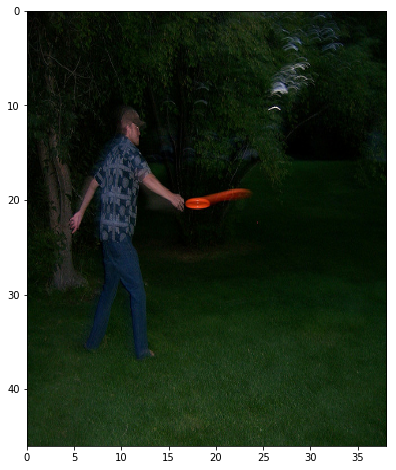

In [81]:
#input
v.show_pafs_kpts_img(true_img,true_paf.numpy(),true_kpts.numpy(),1,1)

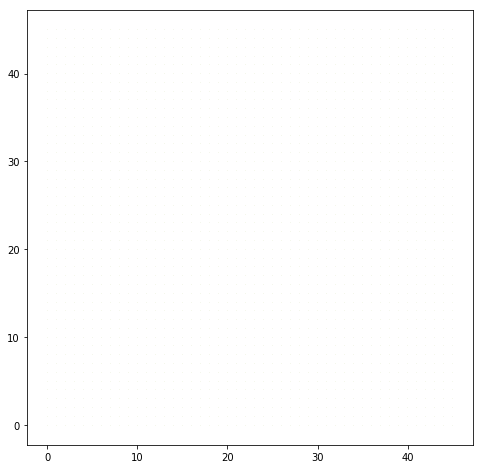

In [58]:
v.show_pafs_kpts_img(None,results[1][0],None,1,1) #can be used to draw the tensor data

# !!!!!!!IT IS FUCKING WORKING!!!!!!!